In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
#from pandas_ml import ConfusionMatrix
from matplotlib import pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.ensemble import RandomForestClassifier

import itertools
import numpy as np
import re
import io

In [ ]:
# Load in the data

In [ ]:
 from google.colab import files
 uploaded = files.upload()

Saving train.tsv to train (1).tsv


In [ ]:
# Load the dataset into a DataFrame
df_train = pd.read_csv(io.BytesIO(uploaded['train.tsv']), sep='\t',header=None)
 

In [ ]:
#NLTK Stop words
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [ ]:
# Download stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# df_test = pd.read_csv("C:/Users/James/Documents/Spring-2021/Mining Massive Datasets/liar_dataset/test.tsv", sep='\t',header=None)
# df_train = pd.read_csv("C:/Users/James/Documents/Spring-2021/Mining Massive Datasets/liar_dataset/train.tsv", sep='\t',header=None)
# df_valid = pd.read_csv("C:/Users/James/Documents/Spring-2021/Mining Massive Datasets/liar_dataset/valid.tsv", sep='\t',header=None)

## Data Preparation

In [ ]:
# Isolate Real news and Fake news into their on DataFrame respectively 

df_real = df_train[(df_train[1] =="half-true" ) | (df_train[1] =="mostly-true" ) | (df_train[1] =="true" ) ]
df_fake = df_train[(df_train[1] =="false" ) | (df_train[1] =="barely-true" ) | (df_train[1] =="pants-fire" ) ]

In [ ]:
# Get the length of the of the distributio of real news in the dataset
len(df_real)

5752

In [ ]:
# Get the length of the of the distributio of fake news in the dataset
len(df_fake)

4488

In [ ]:
# Extract random rows to match the unbalanced Real News dataset
test = df_real.sample(4688)
frames = [test, df_fake ]
df_train_data = pd.concat(frames)

In [ ]:
# Isolate unknown columns
df_credit = df_train_data[[8,9, 10, 11, 12]]

In [ ]:
# drop the first column from the dataset
df_train = df_train_data[[1,2,4,5,6,7,8,9,10,11,12,13]]

In [ ]:
#df_train.rename(columns={1:"label"},inplace=True)

In [ ]:
# Rename the columns from the dataset to more represent what is contained inside
# said dataset
df_train_data.rename(columns={0:"file",1:"label",2:"Overview",3:"Headline",4:"Author",5:"Authors_Title",6:"State_Info",7:"Party",8:"Credit_One",9:"Credit_Two",10:"Credit_Three",11:"Credit_Four",12:"Credit_Five",13:"Venue"},inplace=True)

# Convert the unidentified columns in the dataset to a string
df_train_data[['Credit_One', 'Credit_Two', 'Credit_Three','Credit_Four','Credit_Five']] = df_train_data[['Credit_One', 'Credit_Two', 'Credit_Three','Credit_Four','Credit_Five']].astype(str)

In [ ]:
df_train_data["label"].value_counts()

false          1995
half-true      1703
barely-true    1654
mostly-true    1622
true           1363
pants-fire      839
Name: label, dtype: int64

In [ ]:
# Create a Dictionary that that would collapse the above out put that only
# has real news ( 1 ) and fake news ( 0 )
thisdict = {
  "barely-true": "0",
  "false": "0",
  "half-true" : "1",
  "mostly-true" : "1",
  "pants-fire" : "0",
  "true" : "1"
}

In [ ]:
# returns the value that matches with the key in the delcared dictionary above
def real_news_or_fake_news(x):
    for k,v in thisdict.items():
        if x == k:
            x = str(v)
            return x

In [ ]:
# convert all rows inside the label column to either a 1 or 0
df_train_data["label"] = df_train_data.apply( lambda x: real_news_or_fake_news(x["label"]), axis= 1 )

In [ ]:
#NLTK Stop words
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [ ]:
# Preform a deep copy of the dataset into another variable 
messages = df_train_data.copy(deep=True)

In [ ]:
# Fill all Nan values with the string Unknown
messages["Author"].fillna('Unknown', inplace=True)
messages["Party"].fillna('Unknown', inplace=True)
messages["Authors_Title"].fillna('Unknown', inplace=True)
messages["State_Info"].fillna('Unknown', inplace=True)
messages["Venue"].fillna('Unknown', inplace=True)

# Replace rows with none to the string Unknown
messages["Party"].replace("none", "Unknown",inplace=True)

In [ ]:
# Fill all Nan values with a 0
messages['Credit_One'] = messages['Credit_One'].replace(np.nan, 0)
messages['Credit_Two'] = messages['Credit_Two'].replace(np.nan, 0)
messages['Credit_Three'] = messages['Credit_Three'].replace(np.nan, 0)
messages['Credit_Four'] = messages['Credit_Four'].replace(np.nan, 0)
messages['Credit_Five'] = messages['Credit_Five'].replace(np.nan, 0)

In [ ]:
# Remove newlines, special characters, links and etcs from incoming string
import string
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text


In [ ]:
# Apply the wordopt modification to all respected columns below

messages["Overview"] = messages["Overview"].apply(wordopt)
messages["Party"] = messages["Party"].apply(wordopt)
messages["Authors_Title"] = messages["Authors_Title"].apply(wordopt)
messages["Author"] = messages["Author"].apply(wordopt)
messages["Venue"] = messages["Venue"].apply(wordopt)
messages["State_Info"] = messages["State_Info"].apply(wordopt)


In [ ]:
# Preform a concatination of all available into one row
# and return a Series
df_new = messages['Overview'].astype(str) + messages['Authors_Title'] + " " + messages['Author'] + " " + messages['State_Info'] + " " + messages['Author'] + " " + messages['Venue'] + " " + messages['Credit_One'] + " " + messages['Credit_Two'] + " " + messages['Credit_Three'] + " " + messages['Credit_Four'] + " " + messages['Credit_Five']

In [ ]:
# Convert the above Series back into a dataframe
df_new = pd.DataFrame(df_new)

In [ ]:
# Display 5 rows of our newly created DataFrame
df_new.head(5)

,0
7623,former business partner robert gay says the m...
1543,casualties and deaths are at their lowest po...
3714,in new york when she ran for reelection she ...
7869,says donald trump in his campaign announcemen...
3097,says newt gingrich aligned with nancy pelosi o...


In [ ]:
# Rename the column of our DataFrame to a string
df_new.rename(columns={0:'text' },inplace=True)

In [ ]:
# Display the frist row of our Dataframe. Which shows all of our columns
# now merged into one row
df_new["text"].iloc[0]

'former business partner robert gay says  the man who helped save my daughter was mitt romney former governor mitt romney massachusetts mitt romney unknown 34.0 32.0 58.0 33.0 19.0'

In [ ]:
# frames1 = [df_new,df_json]
# df_train_data = pd.concat(frames1, axis=1)
#df_train_data.reset_index(drop=True, inplace=True)

In [ ]:
# Drop the `label` column
#df_train_data.drop("label", axis=1, inplace=True)      #where numbering of news article is done that column is dropped in dataset

In [ ]:
# Display our DataFrame
df_new

,text
7623,former business partner robert gay says the m...
1543,casualties and deaths are at their lowest po...
3714,in new york when she ran for reelection she ...
7869,says donald trump in his campaign announcemen...
3097,says newt gingrich aligned with nancy pelosi o...
...,...
10228,stopped by smiley cookie to pick up some great...
10230,the supreme courts views are radically out of ...
10233,mayor fung wants to punish our childrens educa...
10238,on lifting the u s cuban embargo and allowing...


## STEAMMING

 Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing. 

 The degree of inflection may be higher or lower in a language. As you have read the definition of inflection with respect to grammar, you can understand that an inflected word(s) will have a common root form. Let's look at a few examples, 

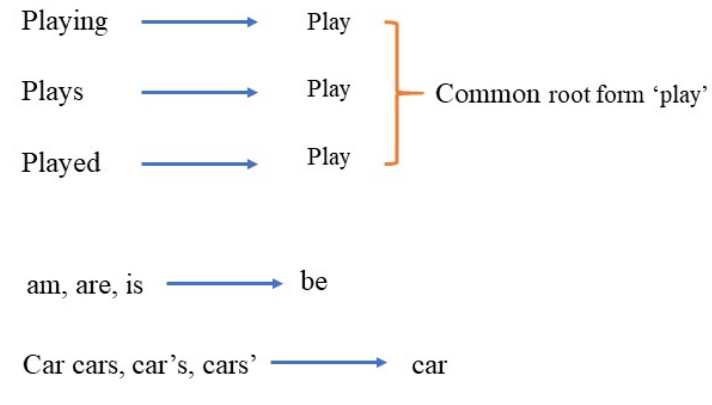

In [ ]:
# Preform a Stemming with Python nltk package so it can reduce the inflection
# in words to their root forms for each row inside our DataFrame and append
# the results to a list
from nltk.stem.snowball import SnowballStemmer
#the stemmer requires a language parameter
snow_stemmer = SnowballStemmer(language='english')
corpus = []
words = []
for i in range(0,len(df_new)):
    review = re.sub('[^a-zA-Z0-9]',' ',df_new["text"].iloc[i])
    review = review.lower()
    review = review.split()
    review = [snow_stemmer.stem(word) for word in review if not word in stopwords.words('english')]
    statements = ' '.join(review)
    corpus.append(statements)
    words.append(review)

In [ ]:
# Clean and combined Stemming words 
def clean_text_data(row):
    # convert text to lower case
    row = row.lower()
    # this line of code remove non letters
    #row = re.sub('[^A-Za-z0-9.]', ' ', row)
    row = row.split()
    review = [ps.stem(word) for word in row if not word in stopwords.words('english')]
    review = ' '.join(review)
    
    return review

In [ ]:
# Apply the above fucntion to all rows of our DataFrame
df_new["text"] = df_new.apply( lambda x: clean_text_data(x["text"]), axis=1)

In [ ]:
df_new["text"].iloc[0]

'former busi partner robert gay say man help save daughter mitt romney former governor mitt romney massachusett mitt romney unknown 34.0 32.0 58.0 33.0 19.0'

In [ ]:
# Rename our unknown columns into a more indentifiable string
df_credit.rename(columns={8:"Credit_One", 9:"Credit_Two",10:"Credit_Three",11:"Credit_Four",12:"Credit_Five"},inplace=True)

# Preform a one hot encoding on our unknown dataset
one_hot = pd.get_dummies(df_credit, columns=['Credit_One',"Credit_Two","Credit_Three","Credit_Four","Credit_Five"])


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#one_hot.rename(columns={0:"file"},inplace=True)
one_hot

,Credit_One_0.0,Credit_One_1.0,Credit_One_2.0,Credit_One_3.0,Credit_One_4.0,Credit_One_5.0,Credit_One_6.0,Credit_One_7.0,Credit_One_8.0,Credit_One_9.0,Credit_One_10.0,Credit_One_11.0,Credit_One_12.0,Credit_One_13.0,Credit_One_14.0,Credit_One_15.0,Credit_One_16.0,Credit_One_17.0,Credit_One_18.0,Credit_One_19.0,Credit_One_26.0,Credit_One_28.0,Credit_One_30.0,Credit_One_31.0,Credit_One_33.0,Credit_One_34.0,Credit_One_36.0,Credit_One_40.0,Credit_One_63.0,Credit_One_70.0,Credit_Two_0.0,Credit_Two_1.0,Credit_Two_2.0,Credit_Two_3.0,Credit_Two_4.0,Credit_Two_5.0,Credit_Two_6.0,Credit_Two_7.0,Credit_Two_8.0,Credit_Two_9.0,...,Credit_Four_7.0,Credit_Four_8.0,Credit_Four_10.0,Credit_Four_11.0,Credit_Four_12.0,Credit_Four_14.0,Credit_Four_15.0,Credit_Four_16.0,Credit_Four_18.0,Credit_Four_19.0,Credit_Four_23.0,Credit_Four_24.0,Credit_Four_33.0,Credit_Four_34.0,Credit_Four_35.0,Credit_Four_37.0,Credit_Four_40.0,Credit_Four_41.0,Credit_Four_76.0,Credit_Four_163.0,Credit_Five_0.0,Credit_Five_1.0,Credit_Five_2.0,Credit_Five_3.0,Credit_Five_4.0,Credit_Five_5.0,Credit_Five_6.0,Credit_Five_7.0,Credit_Five_8.0,Credit_Five_9.0,Credit_Five_10.0,Credit_Five_11.0,Credit_Five_15.0,Credit_Five_16.0,Credit_Five_18.0,Credit_Five_19.0,Credit_Five_36.0,Credit_Five_44.0,Credit_Five_61.0,Credit_Five_105.0
7623,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1543,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7869,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3097,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10228,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
10233,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10238,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Check if there is any null values inside our one_hot DataFrame
one_hot.isnull().values.any()

False

In [ ]:
# Check if there is any null values inside our DataFrame
df_new.isnull().values.any()

False

In [ ]:
#df_next = pd.merge(df_new, df_credit, on="file", how='inner')
df_new.head(2)

,text
7623,former busi partner robert gay say man help sa...
1543,casualti death lowest point sinc liter begin w...


In [ ]:
df_new.columns

Index(['text'], dtype='object')

In [ ]:
# Make training and test sets 
#X_train, X_test, y_train, y_test = train_test_split(df_new['text'], y, test_size=0.30, random_state=53)

# Choose an Alogorithm 

In [ ]:
# Preform a Tokenization of our text dataset. 
# These words need to then be encoded as integers.
# Set max features to lenght of dataset
count = CountVectorizer(max_features=9176,ngram_range=(1,1))
X_count = count.fit_transform(corpus).toarray()

# Preform a Tokenization of our text dataset. 
# These words need to then be encoded as Floats then
tfidf = TfidfVectorizer(max_features=9176,ngram_range=(1,1))
X_tfidf = tfidf.fit_transform(corpus).toarray()

In [ ]:
# Store our true values of our model in the Y variable 
Y =messages["label"]

In [ ]:
X_train_count,X_test_count,Y_train_count,Y_test_count = train_test_split(X_count,Y,test_size=0.35,random_state = 27) # 65% training and 35% test
X_train_tfidf,X_test_tfidf,Y_train_tfidf,Y_test_tfidf = train_test_split(X_tfidf,Y,test_size=0.35,random_state = 27) # 65% training and 35% test

# Building the Count and Tfidf Vectors

In [ ]:
# Create a DataFrame from our newly created CountVectorizer
df_count = pd.DataFrame(X_train_count,columns = tfidf.get_feature_names())
df_count.head()

,10,105,11,114,12,13,14,15,16,160,163,17,18,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,51,58,...,youthpass,youtub,youv,yrs,yu,yulin,yuma,yuppi,yuri,yvett,zaccaria,zach,zack,zaffirini,zakaria,zandi,zanesvill,zant,zawahiri,zedler,zeldin,zelenik,zell,zenzing,zepecki,zephyr,zerban,zero,zielinski,ziemer,zika,zimmerman,zinn,zip,zipper,zippo,zombi,zone,zoo,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Create a DataFrame from our newly created TFIDF-Vectorizer
df_tfidf = pd.DataFrame(X_train_tfidf,columns = tfidf.get_feature_names())
df_tfidf.head()

,10,105,11,114,12,13,14,15,16,160,163,17,18,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,51,58,...,youthpass,youtub,youv,yrs,yu,yulin,yuma,yuppi,yuri,yvett,zaccaria,zach,zack,zaffirini,zakaria,zandi,zanesvill,zant,zawahiri,zedler,zeldin,zelenik,zell,zenzing,zepecki,zephyr,zerban,zero,zielinski,ziemer,zika,zimmerman,zinn,zip,zipper,zippo,zombi,zone,zoo,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# The multinomial Naive Bayes classifier is suitable for classification with discrete 
# features (e.g., word counts for text classification). The multinomial 
# distribution normally requires integer feature counts. However, in practice, fractional 
# counts such as tf-idf may also work.

# Respectively for both countVecotr and tfidfVecotr
classfier_count = MultinomialNB(alpha=0.1)
classfier_tfidf = MultinomialNB(alpha=0.1)

# Naive Bayes classifier for Multinomial model 

In [ ]:
classfier_count.fit(X_train_count,Y_train_count)
Y_pred_count = classfier_count.predict(X_test_count)
classfier_tfidf.fit(X_train_tfidf,Y_train_tfidf)
Y_pred_tfidf = classfier_tfidf.predict(X_test_tfidf)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
acc_count = accuracy_score(Y_test_count,Y_pred_count)
classification_count = classification_report(Y_test_count,Y_pred_count)
confusion_matrix_count = confusion_matrix(Y_test_count,Y_pred_count)
acc_tfidf = accuracy_score(Y_test_tfidf,Y_pred_tfidf)
classification_tfidf = classification_report(Y_test_tfidf,Y_pred_tfidf)
confusion_matrix_tfidf = confusion_matrix(Y_test_tfidf,Y_pred_tfidf)

In [ ]:
print("FOR COUNT VECTORIZER: \n")
print(" \n Accuracy : ",acc_count,"\n","Classification report \n",classification_count,"\n","Confusion matrix \n",confusion_matrix_count,"\n\n\n")
print("FOR TFIDF VECTORIZER: \n")
print(" \n Accuracy : ",acc_tfidf,"\n","Classification report \n",classification_tfidf,"\n","Confusion matrix \n",confusion_matrix_tfidf)

FOR COUNT VECTORIZER: 

 
 Accuracy :  0.5877957658779577 
 Classification report 
               precision    recall  f1-score   support

           0       0.58      0.56      0.57      1551
           1       0.60      0.62      0.61      1661

    accuracy                           0.59      3212
   macro avg       0.59      0.59      0.59      3212
weighted avg       0.59      0.59      0.59      3212
 
 Confusion matrix 
 [[ 864  687]
 [ 637 1024]] 



FOR TFIDF VECTORIZER: 

 
 Accuracy :  0.5877957658779577 
 Classification report 
               precision    recall  f1-score   support

           0       0.58      0.55      0.56      1551
           1       0.60      0.62      0.61      1661

    accuracy                           0.59      3212
   macro avg       0.59      0.59      0.59      3212
weighted avg       0.59      0.59      0.59      3212
 
 Confusion matrix 
 [[ 850  701]
 [ 623 1038]]


# Building a RandomForest Classifier

In [ ]:
#Create a Gaussian Classifier
RFC = RandomForestClassifier(n_estimators=200, random_state=0)

#Train the model using the training sets y_pred=clf.predict(X_test_count)
# CountVector
RFC.fit(X_train_count , Y_train_count)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:

RFC.score(X_test_count, Y_test_count)

0.6198630136986302

In [ ]:
y_pred = RFC.predict(X_test_count)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test_count,y_pred))
print(classification_report(Y_test_count,y_pred))



[[ 935  616]
 [ 605 1056]]
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      1551
           1       0.63      0.64      0.63      1661

    accuracy                           0.62      3212
   macro avg       0.62      0.62      0.62      3212
weighted avg       0.62      0.62      0.62      3212



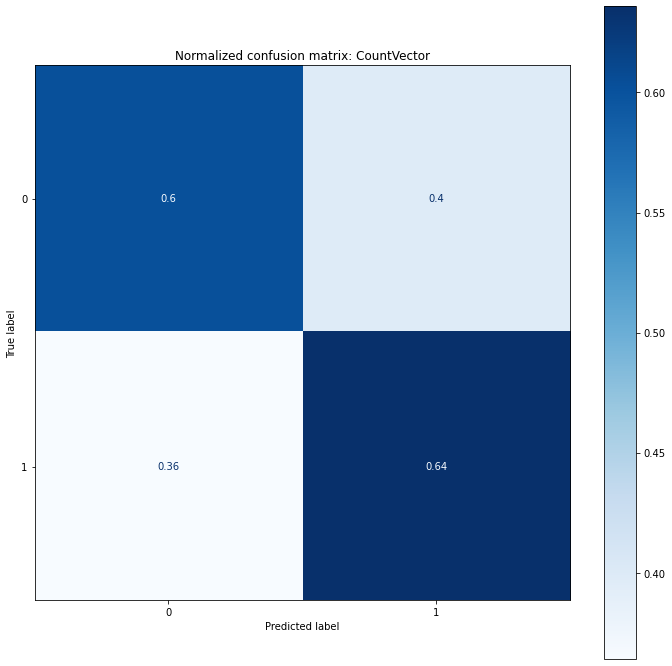

RFC Confusion Matrix


In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title('Normalized confusion matrix: CountVector')
plot_confusion_matrix(RFC, X_test_count, Y_test_count, normalize='true', cmap=plt.cm.Blues, ax=ax)

plt.show()
print("RFC Confusion Matrix")

In [ ]:
# Gather the feature importance so we can visual see what words were of the most
# important throughout our dataset
my_list = []


importances = RFC.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFC.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_count.shape[1]):
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    inc= (f + 1, indices[f], importances[indices[f]])
    my_list.append([df_count.iloc[:,inc[1]].name,(f + 1, indices[f], importances[indices[f]])])

Feature ranking:


In [ ]:
list_two = []
for p in my_list:
    list_two.append([p[0], p[1][2]])
df_importance = pd.DataFrame(list_two,columns=['features','importance'])

In [ ]:
df_importance.sort_values(by='importance', ascending=False)#df.sort_values(by='col1', ascending=False)

,features,importance
0,unknown,0.005845
1,percent,0.005045
2,say,0.004402
3,state,0.004318
4,obama,0.004242
...,...,...
8199,tanner,0.000000
8198,houthi,0.000000
8197,obvious,0.000000
8196,tx,0.000000


In [ ]:
#df_importance.sort_values(by='importance', ascending=False)